# STAT 201 Group 43 - Group Project Proposal

## Title: Determining whether a mutant strain of the nematode C. elegans slows its rate of locomotion when in the presence of nutrients

In [36]:
# Please run this cell before continuing, installing packages if necessary.
library(tidyverse)
library(RColorBrewer)
library(tidymodels)
set.seed(2023)
options(repr.plot.width = 10, repr.plot.height = 6)

## Introduction

**Background:** Parkinson’s disease (PD) is a neurodegenerative disease, and its symptoms are thought to be due in part to depletion of the transmission of a neurotransmitter called dopamine between neurons in the brain. In an effort to characterize genes associated with Parkinson's disease in humans to determine whether they are truly relevant to the pathology of PD, the nematode Caenorhabditis elegans can be studied due to its expression of functionally equivalent (orthologous) genes.

In this project, the effects of a mutation in the ortholog of a PD-associated gene, which renders the gene dysfunctional, will be examined.  Specifically, we will look at the effects on the basal slowing response, which is a dopamine-dependent slowing behaviour exhibited by *C. elegans* when in the presence of food. A lack of slowing while on food is indicative of insufficient dopamine neurotransmission. CB1112 is the name of the mutant strain of *C. elegans* we will be using, as it is known to be deficient in dopamine.

**Our question:** Is there a difference in the mean rate of locomotion of CB1112 worms on food and CB1112 worms not on food?

**Our dataset:** The dataset being used was acquired using the Rankin Lab’s Multi-Worm Tracker, which allows for the tracking of C. elegans behaviour. The dataset contains measurements of many variables throughout a 420-second experiment in which many CB1112 C. elegans were allowed to crawl either in the presence of food or in the absence of food. The main variable that will be focused on is the speed at which the worms were crawling.

## Preliminary results

In [37]:
# Load dataset
worm_data_raw <- read_csv('N2_CB1112_baseline_output_12_11_2022.csv', show_col_types = FALSE)

head(worm_data_raw)
nrow(worm_data_raw)

time_bin,worm,time,speed,x,y,angularspeed,pathlength,kink,bias,curve,dir,crab,length,midline,width,morphwidth,area,Strain
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
5,27,4.707,0.2312,23.73,29.97,10.880,0.07470,57.80,1,42.10,0,0.02003,0.7560,0.9690,0.2386,0.0867,0.0871,N2_Food
5,156,4.484,0.2195,36.94,25.75,7.300,0.13040,34.50,1,31.17,0,0.02087,0.9320,1.0360,0.1998,0.1648,0.1556,N2_Food
5,185,4.715,0.2563,25.62,24.98,34.660,0.08360,38.50,1,30.64,0,0.02118,0.7200,0.9310,0.2660,0.1404,0.1324,N2_Food
5,192,4.600,0.1354,28.47,19.23,5.484,0.06230,28.60,1,26.06,0,0.00981,0.5806,0.8200,0.1979,0.1378,0.1079,N2_Food
5,198,4.715,0.1797,24.28,30.77,3.680,0.05940,48.56,1,35.38,0,0.01484,0.7950,0.9263,0.1696,0.1467,0.1315,N2_Food
5,208,4.824,0.2135,27.83,25.23,5.035,0.05133,51.94,1,34.78,0,0.00853,0.8657,0.9717,0.2160,0.1774,0.1526,N2_Food


[1] 252756

In [38]:
# Select worm, speed, and Strain columns
# Filter observations with Strain "CB1112_Food" and "CB1112_NoFood"
# Calculate average speed of each worm

worm_data_cleaned <- worm_data_raw |>
    select(worm, speed, Strain) |>
    filter(Strain %in% c("CB1112_Food", "CB1112_NoFood")) |>
    group_by(Strain, worm) |>
    summarize(speed = mean(speed))

head(worm_data_cleaned)
nrow(worm_data_cleaned)

`summarise()` has grouped output by 'Strain'. You can override using the
`.groups` argument.


Strain,worm,speed
<chr>,<dbl>,<dbl>
CB1112_Food,1,0.2243345
CB1112_Food,2,0.1039276
CB1112_Food,3,0.1803790
CB1112_Food,4,0.2429433
CB1112_Food,6,0.2389154
CB1112_Food,7,0.1302114


[1] 932

In [39]:
# Rename the column "Strain" as "food_status"
colnames(worm_data_cleaned)[1]  <- "food_status"

# Change "CB1112_Food" to "Food", "CB1112_NoFood" to "NoFood"
worm_data_cleaned$food_status[worm_data_cleaned$food_status=="CB1112_Food"] <- "Food"
worm_data_cleaned$food_status[worm_data_cleaned$food_status=="CB1112_NoFood"] <- "NoFood"

head(worm_data_cleaned)
nrow(worm_data_cleaned)

d1 <- worm_data_cleaned %>% filter(food_status == "Food")
nrow(d1)
d2 <- worm_data_cleaned %>% filter(food_status == "NoFood")
nrow(d2)

food_status,worm,speed
<chr>,<dbl>,<dbl>
Food,1,0.2243345
Food,2,0.1039276
Food,3,0.1803790
Food,4,0.2429433
Food,6,0.2389154
Food,7,0.1302114


[1] 932

[1] 521

[1] 411

#### Table 1. Mean, Standard Deviation, Number of Observations Across *Food* and *NoFood* Groups

In [40]:
# Create Table 1
summary <- worm_data_cleaned |>
    group_by(food_status) |>
    summarize(mean = mean(speed),
              median = median(speed),
              sd = sd(speed),
              n = n())
summary

food_status,mean,median,sd,n
<chr>,<dbl>,<dbl>,<dbl>,<int>
Food,0.1799004,0.1842810,0.04499372,521
NoFood,0.2018251,0.2052696,0.04383005,411


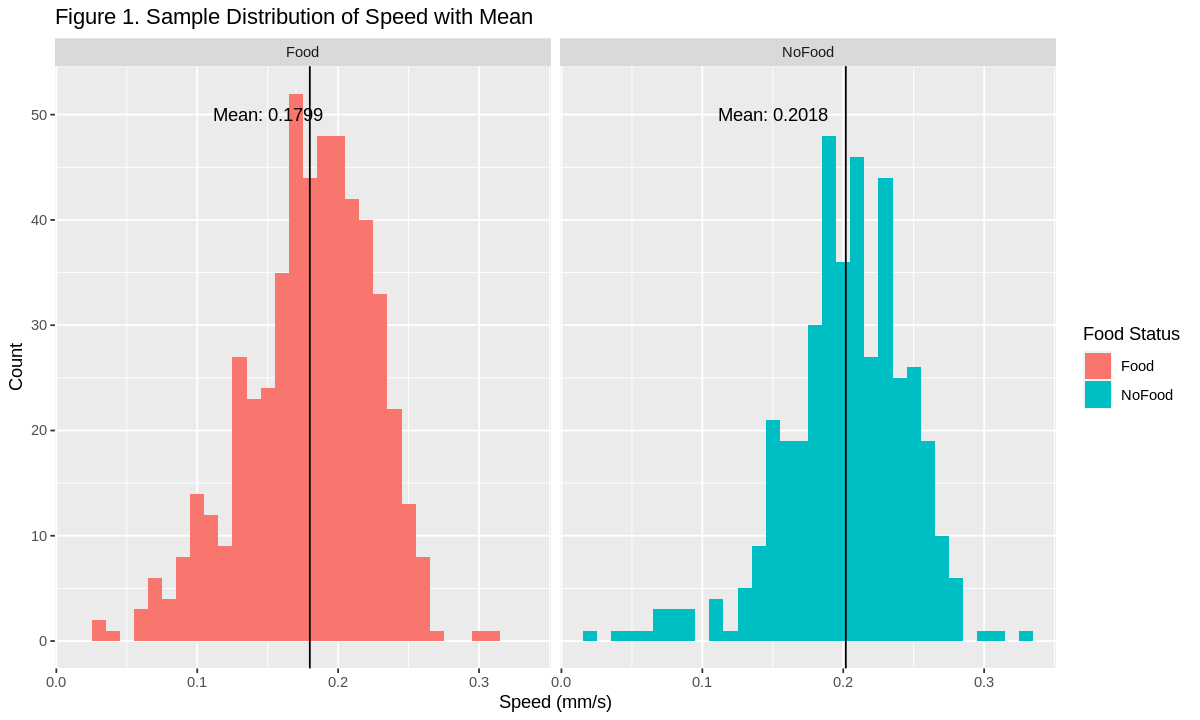

In [44]:
# Create histogram
hist <- worm_data_cleaned |>
    ggplot(aes(x = speed, fill = food_status)) +
    geom_histogram(binwidth = 0.01) +
    geom_vline(data = tibble(food_status = c("Food", "NoFood"), sample_mean = summary$mean), 
               aes(xintercept = sample_mean)) +
    geom_text(data = tibble(food_status = c("Food", "NoFood"), sample_mean=summary$mean),
              mapping = aes(x = 0.15, y = 50, label=paste("Mean:", round(sample_mean, 4)))) +
    facet_wrap(~food_status) +
    labs(x = "Speed (mm/s)",
         y = "Count",
         title = "Figure 1. Sample Distribution of Speed with Mean",
         fill = "Food Status")

hist

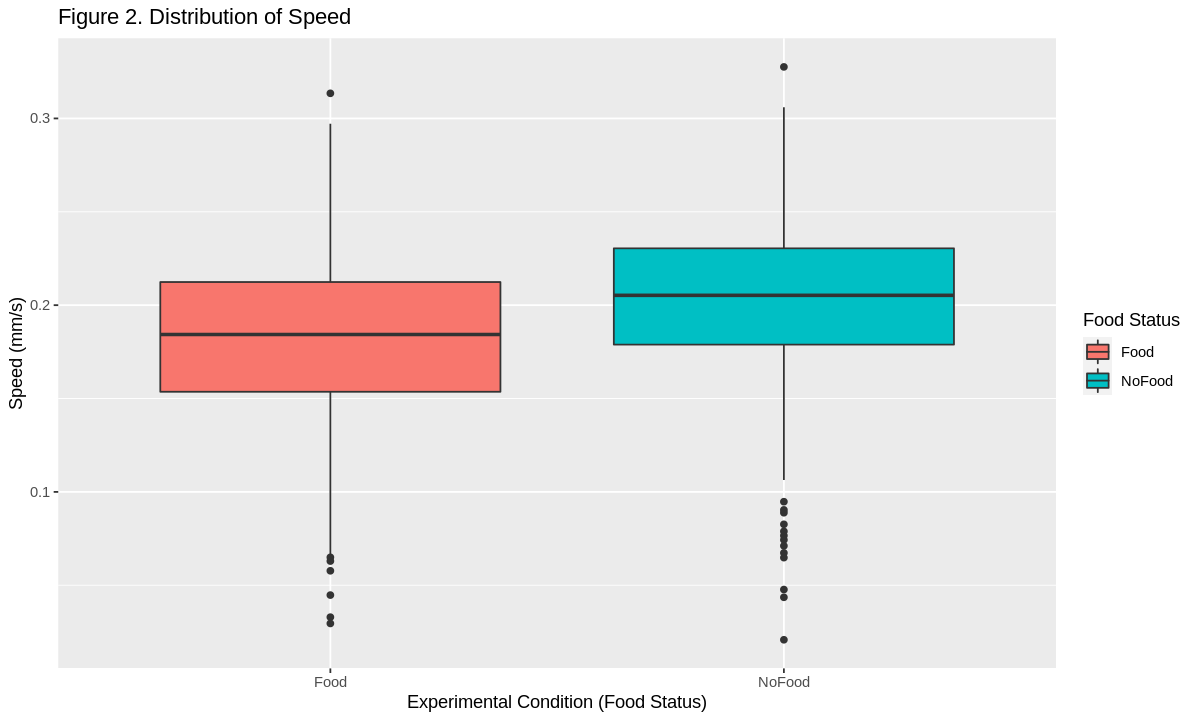

In [45]:
# Create boxplot
boxplot <- worm_data_cleaned |>
    ggplot() +
    geom_boxplot(aes(food_status, speed, fill = food_status)) +
    labs(x = "Experimental Condition (Food Status)",
         y = "Speed (mm/s)",
         title = "Figure 2. Distribution of Speed",
         fill = "Food Status")

boxplot

## Methods: Plan

**Trustworthiness**
* The experiment from which this data was obtained was performed by Ben (group member) under the supervision of Dr. Catharine Rankin, and it was performed in a strictly controlled environment in which conditions such as temperature and humidity were held constant.
    * Ben has over a year of experience with experimenting on and handling *C. elegans*.

**Some imperfection of plots & estimates**
* We can observe from the side-by-side boxplot that the dataset contains many outliers which affects the visualization, and more importantly, may indicate inaccurate mean values in our graph.
* We can use a hypothesis test to compare the means of the two sample groups, making our results more reliable and convincing.

**Hypothesis Test**

$\bar{x}_{1}$: mean rate of locomotion (speed), CB1112 worms with no food

$\bar{x}_{2}$: mean rate of locomotion (speed), CB1112 worms on food

$H_0$: $\bar{x}_{1}-\bar{x}_{2}=0$

$H_1$: $\bar{x}_{1}-\bar{x}_{2}\neq0$

We plan to conduct a two-sample independent t-test, as the two samples are independent of one another. Also, our sample size is large enough (521 individuals in *"Food"* group and 411 individuals in *NoFood* group), indicating that we are qualified to use CLT. 

In order to get the confidence interval, we can either compute manually ( $(\bar{x}_{1} - \bar{x}_{2}) \pm t * se(\bar{x}_{1} - \bar{x}_{2})$ ) or we can directly use R's `t.test()` function to compute the confidence interval.

**What do you expect to find?**
* We expect to find little difference between the mean speed of CB1112 worms in food and the mean speed of CB1112 worms with no food, meaning **we expect to *fail to reject* $H_0$**.

**What impact could such findings have?**
* By comparing the behavioural and morphological profiles of *C. elegans* strains carrying loss-of-function mutations in orthologs of PD-associated genes, it is possible to help characterize the roles their human equivalents may play in PD and how they might interact with one another. Such findings might set another powerful building block on the road to treating Parkinson's disease.

**Future questions this could lead to:**
* Which Parkinson's-associated genes in humans are involved in dopamine transmission?
* If the mutation experiment of C. elegans succeeds, what implications does this have for treating Parkinson's?

## References

[placeholder]